# Lorenz Butterfly Effect - Fluttering Chaotically with Machine Learning

<center>January 7th, 2024 </center>
<center>Universidad de Sevilla</center>

<center>Craig Michie</center>

<hr>

The purpose of this project is to explore concepts of neural networks and predictive models to broaden our understanding of these programming techniques. This is accomplished through modeling the lorenz butterfly effect with an Recursive Neural Network (RNN) and Artificial Neural Network (ANN) and comparing the results to the lorenz butterfly with the original lorenz butterfly and changing paramaters and initial state.

In [1]:
"""
Firstly to import the required packages used in the notebook - please ensure these packages are downloaded
"""
##Lorenz
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
from matplotlib.widgets import Slider, Button
import matplotlib.animation as animation #need to install ipympl
import warnings
from Lorenz import LorenzAttractor

%matplotlib widget

##ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import metrics
from tensorflow.keras import losses, backend

from tqdm.keras import TqdmCallback
from tqdm import tqdm

##RNN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras import metrics
from tensorflow.keras import losses, backend

warnings.filterwarnings('ignore')

The Lorenz Butterfly is a famous chaos theory example. Chaos theory is the study of dynamical systems that are extremely sensitive to the initial conditions but there are some underlying patterns and deterministics of the problems, some form of self organisation. The butterfly effect describes how a small change in one state of a nonlinear system can result to a large difference in a later state, indicating some sensitivity to initial conditions. With the famous metaphor of a butterfly flapping its wings causing a tornado somewhere else in the world.[1]

### Lorenz Butterfly - The Strange Attractor
The Lorenz attractor (butterfly) is one of the more famous chaotic systems in physics and can be calculated with the system of differential equations $\mathcal{L}$ as

\begin{align}
    \mathcal{L}=
    \begin{cases}
        \dot{X} &= \sigma(Y-X)\\
        \dot{Y} &= -XZ+\rho X-Y\\
        \dot{Z} &= XY-\beta Z
    \end{cases}
\end{align}

here $\sigma$, $\rho$ and $\beta$ are physical parameters. This system of equations is non-linear, deterministic and for certain parameters, the system is also non-periodic and chaotic. Lorenz used parameters:
\begin{align}
    \sigma=10 && \rho=28 && \beta=8/3
\end{align}
It is found these and nearby parameters will reamin chaotic and non-periodic. [2]

The problem here is that extracting the physical parameters given some data may not always be easy or obvious. If the phsyical parameters are known, the deterministic system could be solved and predicted. If a time series of states are given, is it possible to predict the next states without knowing the physical parameters. This becomes a superivsed machine lenaring problem.
<hr>
[1]"chaos theory | Definition & Facts". Encyclopedia Britannica. Retrieved 2019-11-24.
 
[2] Hirsch, Morris W.; Smale, Stephen; Devaney, Robert (2003). Differential Equations, Dynamical Systems, & An Introduction to Chaos (Second ed.). Boston, MA: Academic Press. ISBN 978-0-12-349703-1.

In [2]:
class LorenzAttractor:
    """ Lorenz Butterfly object
        Uses the equations of differential equations with the parameters above to create a 3D plot 
        and provide sliders so we can see how the adjustment of parameters causes changes in the plot
        highlighting the chaos. 
        
        Also to be used to create dataset for the Machine Learning Models to train off of
    """

    def __init__(self, t, initialState, sigma, beta, rho):
        """
        Class for the computation of

            dX/dt = \sigma(Y-X)
            dY/dt = -XZ+\rho X-Y
            dZ/dt = XY-\beta Z

        Args:
            initialState: 3-tuple, (X, Y, Z)=Initial state of the attractor
            sigma: float, represents physical parameter $\sigma$
            beta: float, represents physical parameter $\beta$
            rho: float, represents physical paraneter $\rho$

        Returns:
            None
        """

        self._initialState = initialState
        self._sigma = sigma
        self._beta = beta
        self._rho = rho
        
        self._t = t
        
        self._states = self.__solve(t)
        
        self.update_critical_points()

        return None
    
    def __repr__(self):
        return f""" Lorenz Attractor: (s={self._sigma}, b={self._beta}, 
                    r={self._rho}), L0={self._initialState}
                """

    def __derivatives(self, state, t0):
        """ Puts system of equations into a length 3 array (Xdot, Ydot, Zdot).
            t0 is needed for the integration step implimintaion
        """

        x, y, z = state
        return np.array([self._sigma*(y-x),
                         x*(self._rho-z)-y,
                         x*y-self._beta*z])

    def __solve(self, t):
        """ Integrates to get state of system in time steps specified by t

        Args:
            t: A sequence of time points to solve for the state.
        """

        return scipy.integrate.odeint(self.__derivatives,
                                      self._initialState,
                                      t)

    def set_params(self, sigma, beta, rho):
        """ Setter function for the physical paramters and updates 
            states attributes
        """
        
        self._sigma = sigma
        self._beta = beta
        self._rho = rho
        
        self._states = self.__solve(self._t)
    
    def get_initialState(self):
        return self._initialState
        
    def get_sigma(self):
        return self._sigma
    
    def get_beta(self):
        return self._beta
    
    def get_rho(self):
        return self._rho
        
    def get_states(self):
        """ Getter method for states 
        Returns:
            X, Y, Z
        """
        return self._states[:,0], self._states[:,1], self._states[:,2]
    
    def get_critical_points(self):
        """ Shape (2, 3): [(X,Y,Z), (X,Y,Z)]"""
        self.update_critical_points()
        return self._critical_points
    
    def update_critical_points(self):
        """ Calcualte critical points if self._rho > 1 """
        if self.check_stable_critical_points():
            #Calculate critical points (self._rho > 1)
            self._critical_points = np.array([(np.sqrt(self._beta*(self._rho-1)),
                                      np.sqrt(self._beta*(self._rho-1)),
                                      self._rho-1),
                                     (-np.sqrt(self._beta*(self._rho-1)),
                                      -np.sqrt(self._beta*(self._rho-1)),
                                      self._rho-1)
                                    ])
        else:
            self._critical_points = np.empty((2,3)) # None type objects

    def check_stable_critical_points(self):
        """ get critical points
            https://en.wikipedia.org/wiki/Lorenz_system
        """
        if self._rho > 1:
            return True
        else:
            warnings.warn("No stable critical points")
            return False
        
    def plot(self):
        """ Plots the states as components and in 3-space
        
        returns:
            plot object
        """
        
        fig = plt.figure(constrained_layout=True, figsize=plt.figaspect(.75))
        fig.tight_layout()
        gs = GridSpec(6, 2, 
                      figure=fig,
                      right=1,
                      height_ratios=[1,1,1,.5,.5,.5])

        title = r"Lorenz attractor: $\sigma=${}, $\beta=${}, $\rho=${}"
        
        # Set up subplot layout
        ax1 = fig.add_subplot(gs[0,0], ylabel="X")
        ax2 = fig.add_subplot(gs[1,0], ylabel="Y")
        ax3 = fig.add_subplot(gs[2,0], ylabel="Z")
        ax4 = fig.add_subplot(gs[:,1], projection='3d',
                             xlabel="X", ylabel="Y", zlabel="Z")
        
        axes = (ax1, ax2, ax3, ax4)
        axes[2].set_xlabel('Time')

        # Slider axes
        axSigma = fig.add_subplot(gs[3,0])
        axBeta = fig.add_subplot(gs[4,0])
        axRho = fig.add_subplot(gs[5,0])
        
        # create sliders
        sigmaSlider = Slider(axSigma, 
                             label=r"$\sigma$", 
                             valmin=0, 
                             valmax=20, 
                             valinit=10, 
                             valstep=0.5)
        betaSlider = Slider(axBeta, 
                             label=r"$\beta$", 
                             valmin=0, 
                             valmax=10, 
                             valinit=8/3.0, 
                             valstep=0.1)
        rhoSlider = Slider(axRho, 
                             label=r"$\rho$", 
                             valmin=0, 
                             valmax=50, 
                             valinit=28, 
                             valstep=0.5)
        
        def update(val):
            """ update function for sliders. Plots the new states
                 - will change the states attribute and critical points.

                - removing old lines is funky and critical point markers did not 
                  get removed hence the redundant removal of lines.
                
               returns:
                   figure, ax, and tuple of sliders.
            """
            self.set_params(sigmaSlider.val, betaSlider.val, rhoSlider.val)
            self.update_critical_points()
            cPoint1, cPoint2 = self.get_critical_points()

            for indx in range(4):
                [l.remove() for l in axes[indx].lines] # remove old lines
            
            for indx in range(3): # plot new Lines
                [l.remove() for l in axes[indx].lines] # make sure it's removed
                axes[indx].plot(self._t, self._states[:,indx], 
                                lw=0.75, color='k')

            # plot 3d projection of butterfly
            [l.remove() for l in axes[3].lines] # make sure removed
            axes[3].plot(self._states[:,0],
                         self._states[:,1],
                         self._states[:,2],
                         color='k', lw=0.75)
            axes[3].plot(cPoint1[0],cPoint1[1],cPoint1[2],"ro-")
            axes[3].plot(cPoint2[0],cPoint2[1],cPoint2[2],"ro-")

            # update title
            fig.suptitle(title.format(str(self._sigma), 
                                      str(self._beta), 
                                      str(self._rho)),
                        fontsize=16)
        update(1)
        sigmaSlider.on_changed(update)
        betaSlider.on_changed(update)
        rhoSlider.on_changed(update)
        
        #show plot
        plt.show()

        return fig, axes, (sigmaSlider, betaSlider, rhoSlider)

###### Plotting the Butterfly

In [3]:
# Set up Lorenz attractor shape and initial parameters
INITIALSTATE = (1.0, 1.0, 1.0)
SIGMA = 10.0
BETA = 8/3.0
RHO = 27.0

# Set integration time sequence for solveing
tStart = 0.0
tEnd = 30.0
dt = 0.003

t = np.arange(tStart, tEnd, dt)

# Numerically solve
LA = LorenzAttractor(t, INITIALSTATE, SIGMA, BETA, RHO)
X, Y, Z = LA.get_states()

In [4]:
print(LA)

 Lorenz Attractor: (s=10.0, b=2.6666666666666665, 
                    r=27.0), L0=(1.0, 1.0, 1.0)
                


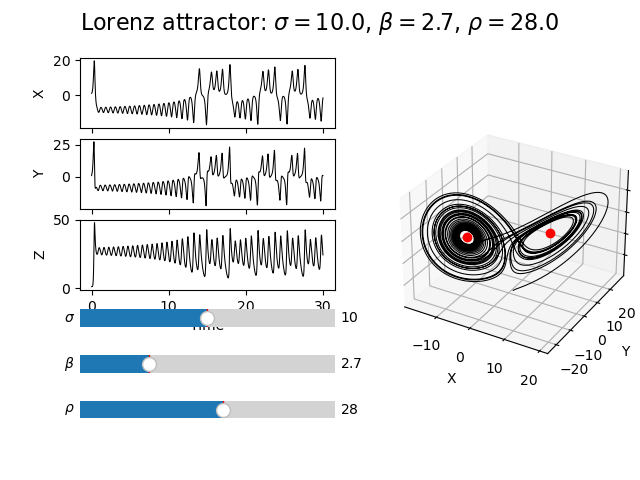

In [5]:
fig, ax, sliders = LA.plot()

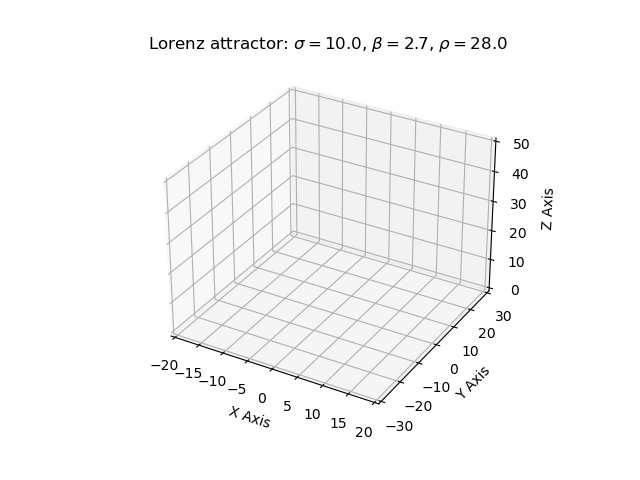

In [6]:
''' Animation of the Lorenz attractor '''

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

def initAnimation():
    trajectory.set_data(X[0],Y[0])
    trajectory.set_3d_properties(Z[0])
    return trajectory,

def animate(i):
    trajectory.set_data(X[:i], Y[:i])
    trajectory.set_3d_properties(Z[:i])
    return trajectory,

trajectory, = ax.plot(X[0], Y[0], Z[0], lw=0.75)
# call the animator.
anim = animation.FuncAnimation(fig, animate, init_func=initAnimation,
                               frames=len(X), interval=1, blit=True, repeat=False)


title = r"Lorenz attractor: $\sigma=${}, $\beta=${}, $\rho=${}"
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title(title.format(str(LA._sigma),str(LA._beta),str(LA._rho)))

# For some reason matplotlib 3d projection is not 
# autochanging the bounds
ax.set_xlim(-20, 20)
ax.set_ylim(-30, 30)
ax.set_zlim(0, 50)

#ax.set_axis_off()
plt.show()

#anim.save('Butterfly.gif', writer='imagemagick', fps=60)

### Machine Learning and Neural Networks

Machine learning (ML) is a field in artifical intelligence that focuses on statistical algorithms that learn from data and are used to predict and perform tasks without explicit instructions.[3] Neural Networks is a branch of machine learning models that are built using neuron networks that mimics the neural networks of animals.[4] 

Neural networks (NNs) are divided into layers with each layer performing different transformations on the respected input. Traditionally a number of hidden layers follows an input layer and finally send information to an output layer. Within the hidden layer exists connection nodes that form and identify hidden correlations and patterns in the data and continues to improve upon itself to increase it's accuracy and predictability capabilities.

There are numerous types of NNs. Recursive Neural Networks (RNN) and Artificial Neural Network (ANN) were chosen for this project since they are two different techniques and are preferred techniques when it comes to the predictions of complex systems.

ANN are a feed-forward network where data is fed into the model and the flow of information is uni-directional meaning the information can only be processed by a singular node after being input and continues to improve with every new input it gets. While RNN are capable to reprocess past data and input data and are capable of remembering data. So when input data is passed, it uses the input data and past data to train. 

To create ANN and RNN models tensorflow and keras packages are used, specifically Sequential due to being user friendly and well documented. 

To evaluate the model, we evaluate the loss and accuracy of both the training and validation. Using the metric 'accuracy', we get the built in metric for the validation quality using the root mean squared error between the predicted value and the validation target data.

$$ RMSE = \sqrt{\frac{\sum_i(X_i - \bar{X})^2}{n}} $$
 
 
 
<hr>
[3] The definition "without being explicitly programmed" is often attributed to Arthur Samuel, who coined the term "machine learning" in 1959, but the phrase is not found verbatim in this publication, and may be a paraphrase that appeared later. Confer "Paraphrasing Arthur Samuel (1959), the question is: How can computers learn to solve problems without being explicitly programmed?" in Koza, John R.; Bennett, Forrest H.; Andre, David; Keane, Martin A. (1996). "Automated Design of Both the Topology and Sizing of Analog Electrical Circuits Using Genetic Programming". Artificial Intelligence in Design '96. Artificial Intelligence in Design '96. Springer, Dordrecht. pp. 151–170. doi:10.1007/978-94-009-0279-4_9. ISBN 978-94-010-6610-5.

[4] Hardesty, Larry (14 April 2017). "Explained: Neural networks". MIT News Office. Retrieved 2 June 2022.


[*] https://keras.io/guides/sequential_model/

[*] https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/

[*] https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

[*] https://www.stsci.edu/~lbradley/seminar/attractors.html#:~:text=The%20Lorenz%20attractor%20is%20an,far%20apart%20at%20later%20times.

In [7]:
def rmse(y_true, y_pred):
    """ Custom metric to pass to the compiler for the model """
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

### RNN Model 

In [8]:
# Set up Lorenz attractor shape and initial parameters
INITIALSTATE = (1.0, 1.0, 1.0)
SIGMA = 10.0
BETA = 8/3.0
RHO = 28.0

# Set integration time sequence for solveing
tStart = 0.0
tEnd = 30.0
dt = 0.001

t = np.arange(tStart, tEnd, dt)
n = len(t)

In [9]:
""" create the dataset"""
LA = LorenzAttractor(t, INITIALSTATE, SIGMA, BETA, RHO)
X, Y, Z = LA.get_states()

TrainingAttractor = np.array([X, Y, Z]).T
print(TrainingAttractor.shape)

lookback = 100 # time steps in sample
trainSize = int(len(TrainingAttractor)*0.75) # 75% of data set

(30000, 3)


In [10]:
# creating rolling timesteps with jump=1
rollingSamples = []
for i in range(len(TrainingAttractor)-lookback):
    rollingSamples.append(np.array(TrainingAttractor[i:lookback+i]))

rollingSamples = np.array(rollingSamples) # make numpy array
print(rollingSamples.shape)

(29900, 100, 3)


In [11]:
# define training and validation sets

trainInput = rollingSamples[:trainSize]
trainOutput = np.array([state for state in trainInput[lookback:,0,:]])


valInput = rollingSamples[trainSize:]
valOutput = np.array([state for state in valInput[lookback:,0,:]])

trainInput, valInput = trainInput[:-lookback], valInput[:-lookback] # remove last sample (won't have known outputs)

# input_shape = (samples, timesteps, dim)
print("Training set input: ", trainInput.shape)
print("Training set output: ",trainOutput.shape)
print("Validation set input: ",valInput.shape)
print("Validation set output: ",valOutput.shape)

Training set input:  (22400, 100, 3)
Training set output:  (22400, 3)
Validation set input:  (7300, 100, 3)
Validation set output:  (7300, 3)


In [12]:
""" Sequential RNN model """
# create the RNN layer:
Model_RNN = Sequential()

Model_RNN.add(LSTM(units=8, 
                   return_sequences=True, # true if using second LSTM layer
                   input_shape=(lookback, 3),
                   dropout=0.2)) # Recurrent Layer

Model_RNN.add(LSTM(units=32, dropout=0.2))
Model_RNN.add(Dense(32, input_dim=3, activation="relu")) # Fully connected layer
Model_RNN.add(Dense(3, activation="linear")) # Fully connected output layer


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000000,
    decay_rate=1e-7)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
Model_RNN.compile(loss=rmse, optimizer=opt, metrics=["accuracy"])
Model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 8)            384       
                                                                 
 lstm_1 (LSTM)               (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 6,787
Trainable params: 6,787
Non-trainable params: 0
_________________________________________________________________


2024-09-18 15:00:55.976410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-18 15:00:55.977298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-18 15:00:55.977761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
""" Train the model """
Model_fitted = Model_RNN.fit(trainInput, trainOutput,
                             epochs=16, #change this for shorter runtimes
                             validation_data=(valInput,
                                              valOutput
                                             ),
                             #Nicer output for more Epochs
                             verbose=1,
                            
                            )
print(Model_fitted.history.keys())

Epoch 1/16


2024-09-18 15:00:56.178478: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-09-18 15:00:56.303144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-18 15:00:56.303690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-18 15:00:56.304166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

697/700 [============================>.] - ETA: 0s - loss: 4.4109 - accuracy: 0.9852

2024-09-18 15:01:08.211423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-18 15:01:08.211884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-18 15:01:08.212338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

700/700 [==============================] - 13s 17ms/step - loss: 4.3993 - accuracy: 0.9852 - val_loss: 3.0208 - val_accuracy: 1.0000
Epoch 2/16
700/700 [==============================] - 12s 17ms/step - loss: 1.3022 - accuracy: 0.9906 - val_loss: 2.2730 - val_accuracy: 1.0000
Epoch 3/16
700/700 [==============================] - 12s 17ms/step - loss: 0.9489 - accuracy: 0.9941 - val_loss: 2.5343 - val_accuracy: 0.9584
Epoch 4/16
700/700 [==============================] - 12s 17ms/step - loss: 0.8064 - accuracy: 0.9971 - val_loss: 2.3018 - val_accuracy: 0.9708
Epoch 5/16
700/700 [==============================] - 12s 17ms/step - loss: 0.7033 - accuracy: 0.9976 - val_loss: 2.4826 - val_accuracy: 0.9659
Epoch 6/16
700/700 [==============================] - 12s 17ms/step - loss: 0.6276 - accuracy: 0.9985 - val_loss: 2.3382 - val_accuracy: 0.9458
Epoch 7/16
700/700 [==============================] - 12s 17ms/step - loss: 0.5841 - accuracy: 0.9983 - val_loss: 2.2167 - val_accuracy: 0.9910
Epo

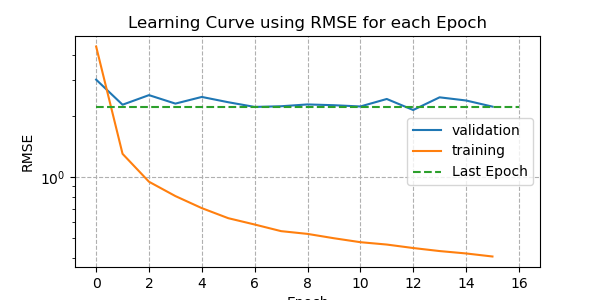

In [14]:
training = Model_fitted.history['loss']
validation = Model_fitted.history['val_loss']

plt.figure(figsize=(6,3))
plt.plot(validation, label="validation")
plt.plot(training, label="training")
plt.plot([0,len(training)],[validation[-1], validation[-1]], label="Last Epoch", ls="--")
plt.yscale("log")
plt.title('Learning Curve using RMSE for each Epoch')
plt.xlabel('Epoch'); plt.ylabel('RMSE')
plt.legend(loc=0); plt.grid(ls="--")

In [15]:
def RNNpredict(Model, initialState, sigma, beta, rho, lookback):
    LA = LorenzAttractor(t, 
                         initialState=initialState, 
                         sigma=sigma, 
                         beta=beta, 
                         rho=rho)
    X, Y, Z = LA.get_states()
    attractor = np.array([X, Y, Z]).T

    # Generate input sequences for prediction
    input_sequences = []
    for i in range(len(LA._t) - lookback):
        input_sequence = attractor[i:i+lookback, :]
        input_sequences.append(input_sequence)

    input_sequences = np.array(input_sequences)

    # Predict using the model
    predicted = Model.predict(input_sequences)

    # Use the same length for time array, attractor, and predicted
    t_corrected = LA._t[:len(attractor)]
    
    # plot
    fig = plt.figure(figsize=plt.figaspect(.5))
    gs = GridSpec(3, 2, figure=fig)

    # Set up subplot layout
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[2,0])
    ax4 = fig.add_subplot(gs[:,1], projection='3d')

    axes = (ax1, ax2, ax3, ax4)
    components = ['x', 'y', 'z']

    for indx in range(3): # Calculate and plot new Lines for each component
        axes[indx].plot(t_corrected, attractor[:,indx], "b--") # numerical
        axes[indx].plot(t_corrected[:-lookback], predicted[:,indx], lw=0.75, color='r') # Predicted
        axes[indx].set_ylabel('component: '+str(components[indx]))
        axes[indx].grid(ls='--')

    # plot 3d projection of butterfly
    axes[3].plot(attractor[:, 0],
                 attractor[:, 1],
                 attractor[:, 2],
                 color='b', lw=0.75)

    axes[3].plot(predicted[:,0],
                 predicted[:,1],
                 predicted[:,2],
                 color='r', lw=0.75)

    # Titles
    title = r"Lorenz attractor: $\sigma=${}, $\beta=${}, $\rho=${}"
    axes[3].set_xlabel("X Axis")
    axes[3].set_ylabel("Y Axis")
    axes[3].set_zlabel("Z Axis")
    axes[3].set_title(title.format(str(LA._sigma),str(LA._beta),str(LA._rho)))

    axes[2].set_xlabel('Time')

    plt.show()

  1/935 [..............................] - ETA: 4:20

2024-09-18 15:04:05.977581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-18 15:04:05.978072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-18 15:04:05.979164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

935/935 [==============================] - 4s 4ms/step


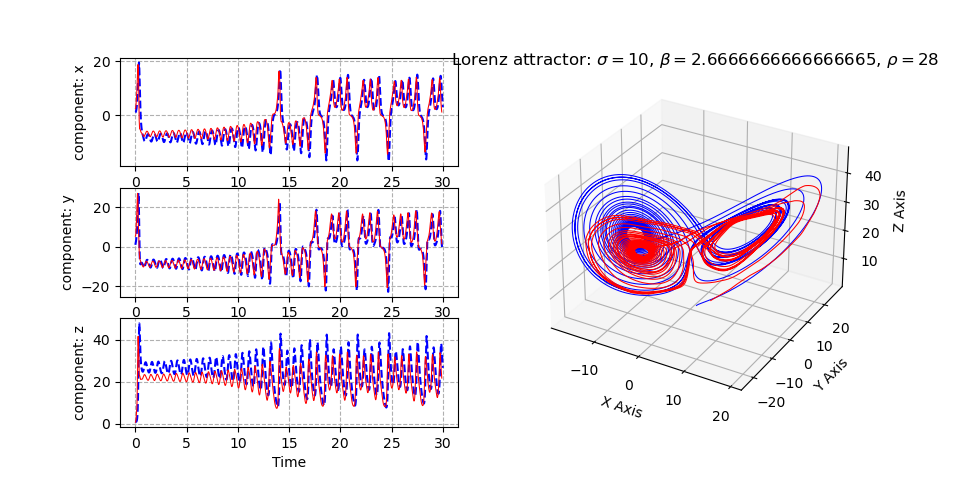

In [16]:
RNNpredict(Model_RNN, (1.0, 1.0, 1.0), 10, 8/3.0, 28, lookback)

935/935 [==============================] - 4s 4ms/step


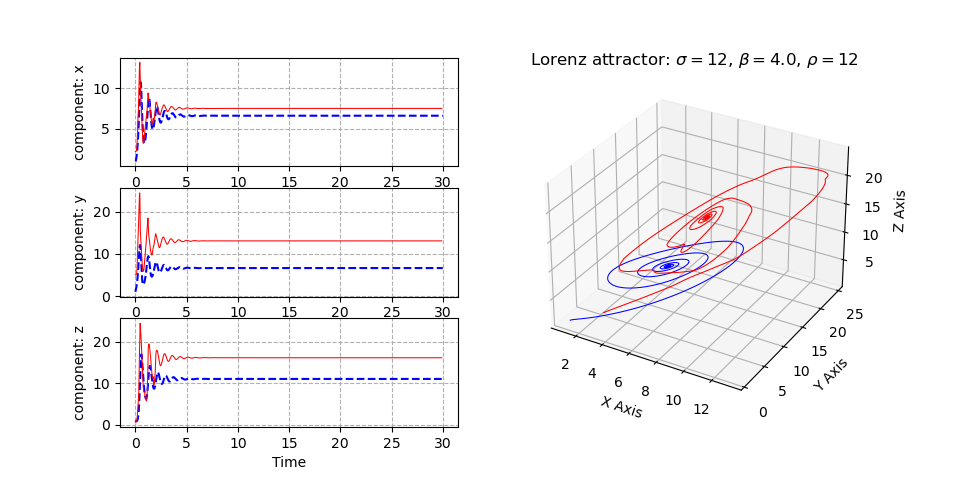

In [17]:
RNNpredict(Model_RNN, (1.0, 1.0, 1.0), 12, 12/3.0, 12, lookback)

935/935 [==============================] - 4s 5ms/step


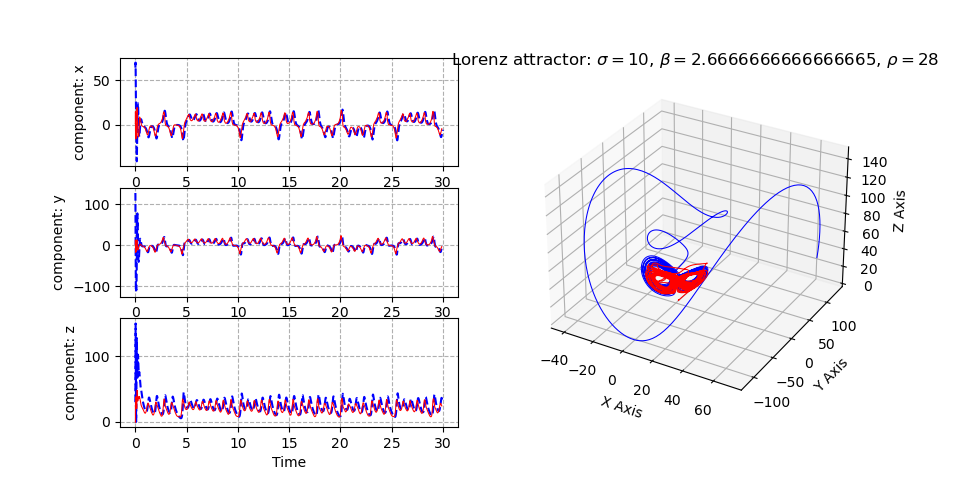

In [18]:
RNNpredict(Model_RNN, (64, 128, 30), 10, 8/3.0, 28, lookback)

The predicted 3d plot from the RNN model for the lorenz butterfly appears to not be accurate but is hard to understand what is going on. When considering the position components plot, it can be observed that the z axis is the one failing to predict the expected behaviour while the x and y coordinates produce more accurate results. This behaviour is also observed for the same initial state while changing the parameters. On the other hand, exaggarating the initial states while keeping the original parameters demonstrates overfitting, as the model cannot accurately predict the behaviour.

The hidden layers of the model were varied considering different activitors of Relu, tanh and linear, the number of units for each long short term memory (LSTM) layer and the decay schedule in attempt to optimise the prediction. 

These errors could be corrected through further adjustment of the LSTM layers parameters of the RNN model and possibly be a result of the implementation of the model. It may be possible that the LSTM layers may not have the capibilities for non-linear systems as the connection between different cells in node are the same as the dense layers. Another possibility is the training dataset does not have the variation it needs for generalization.

## ANN Model

In [19]:
# Set up Lorenz attractor shape and initial parameters
INITIALSTATE = (1.0, 1.0, 1.0)
SIGMA = 10.0
BETA = 8/3.0
RHO = 28.0

# Set integration time sequence for solveing
tStart = 0.0
tEnd = 30.0
dt = 0.001

t = np.arange(tStart, tEnd, dt)

# How far many time steps the model has between input and output 
ndt = 1

In [20]:
""" create the dataset"""
LA = LorenzAttractor(t, INITIALSTATE, SIGMA, BETA, RHO)
X, Y, Z = LA.get_states()
attractor = np.array([X, Y, Z]).T

trainSize = int(len(attractor)*0.7) # 70% of data set
trainInput = attractor[:trainSize]
trainOutput = np.roll(trainInput, -ndt, axis=0)

valInput = attractor[trainSize:] # last 30% of data set
valOutput = np.roll(valInput, -ndt, axis=0)


print("Training set input: ", trainInput.shape)
print("Training set output: ",trainOutput.shape)
print("Validation set input: ",valInput.shape)
print("Validation set output: ",valOutput.shape)

Training set input:  (21000, 3)
Training set output:  (21000, 3)
Validation set input:  (9000, 3)
Validation set output:  (9000, 3)


In [21]:
""" Sequential model """
Model = Sequential()

Model.add(Dense(64, input_dim=3, activation="relu")) # Fully connected input layer

Model.add(Dense(32, activation="relu")) # Fully connected layer

Model.add(Dense(3, activation="linear")) # Fully connected output layer

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000000,
    decay_rate=1e-8)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

Model.compile(loss=rmse, optimizer=opt, metrics=["accuracy"])
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________


In [22]:
""" Train the model """
Model_fitted = Model.fit(trainInput,
                        trainOutput,
                        validation_data=(valInput,
                                        valOutput
                                        ),
                        epochs=32,
                        batch_size=100,
                        # Nicer output for so many Epochs
                        verbose=0,
                        callbacks=[TqdmCallback(verbose=0)]
                        )


0epoch [00:00, ?epoch/s]

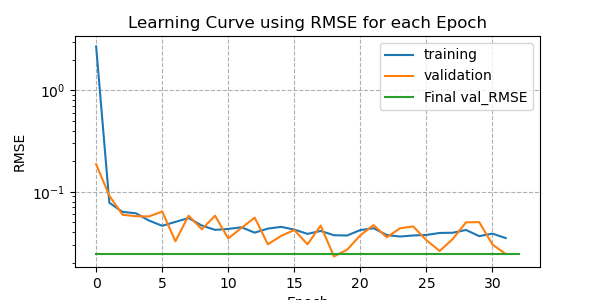

In [23]:
training = Model_fitted.history['loss']
validation = Model_fitted.history['val_loss']

plt.figure(figsize=(6,3))
plt.plot(training, label="training")
plt.plot(validation, label="validation")
plt.plot([0,len(training)],[validation[-1], validation[-1]], label="Final val_RMSE")
plt.yscale("log")
plt.title('Learning Curve using RMSE for each Epoch')
plt.xlabel('Epoch'); plt.ylabel('RMSE')
plt.legend(loc=0); plt.grid(ls="--")

In [24]:
score = Model.evaluate(valInput, valOutput)

282/282 [==============================] - 0s 321us/step - loss: 0.0244 - accuracy: 1.0000


In [25]:
def predict(Model, initialState, sigma, beta, rho):
    """ Predicts and plots states visually and allows parameters of attractor to be adjusted to observe 
    resulting behaviour of initial states and parameters."""
    LA = LorenzAttractor(t, 
                         initialState=initialState, 
                         sigma=sigma, 
                         beta=beta, 
                         rho=rho)
    X, Y, Z = LA.get_states()
    attractor = np.array([X, Y, Z]).T

    predicted = Model.predict(attractor)
    
    # plot
    fig = plt.figure(figsize=plt.figaspect(.5))
    gs = GridSpec(3, 2, figure=fig)

    # Set up subplot layout
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[2,0])
    ax4 = fig.add_subplot(gs[:,1], projection='3d')

    axes = (ax1, ax2, ax3, ax4)
    components = ['x', 'y', 'z']

    for indx in range(3): # Calculate and plot new Lines for each component
        axes[indx].plot(LA._t, attractor[:,indx], "b--") # numerical
        axes[indx].plot(LA._t, predicted[:,indx], lw=0.75, color='r') # Predicted
        axes[indx].set_ylabel('component: '+str(components[indx]))
        axes[indx].grid(ls='--')

    # plot 3d projection of butterfly
    axes[3].plot(attractor[:, 0],
                 attractor[:, 1],
                 attractor[:, 2],
                 color='b', lw=0.75)
    
    axes[3].plot(predicted[:,0],
                 predicted[:,1],
                 predicted[:,2],
                 color='r', lw=0.75)

    


    # Titles
    title = r"Lorenz attractor: $\sigma=${}, $\beta=${}, $\rho=${}"
    axes[3].set_xlabel("X Axis")
    axes[3].set_ylabel("Y Axis")
    axes[3].set_zlabel("Z Axis")
    axes[3].set_title(title.format(str(LA._sigma),str(LA._beta),str(LA._rho)))

    axes[2].set_xlabel('Time')

    plt.show()

938/938 [==============================] - 0s 269us/step


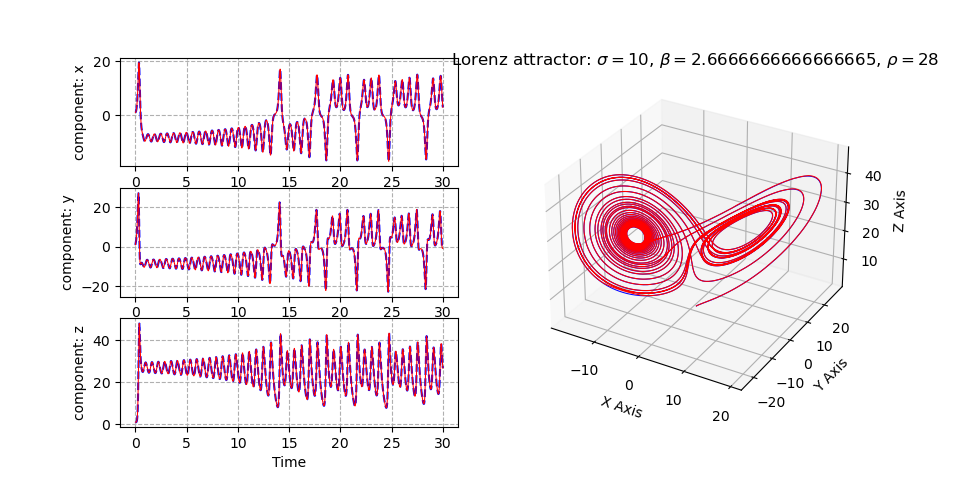

In [26]:
predict(Model, (1.0, 1.0, 1.0), 10, 8/3.0, 28)

938/938 [==============================] - 0s 377us/step


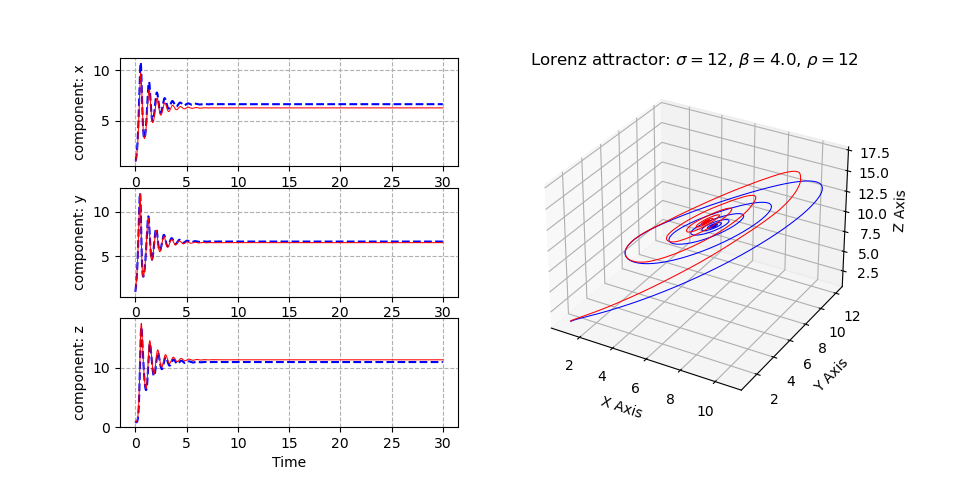

In [27]:
predict(Model, (1.0, 1.0, 1.0), 12, 12/3.0, 12)

938/938 [==============================] - 0s 369us/step


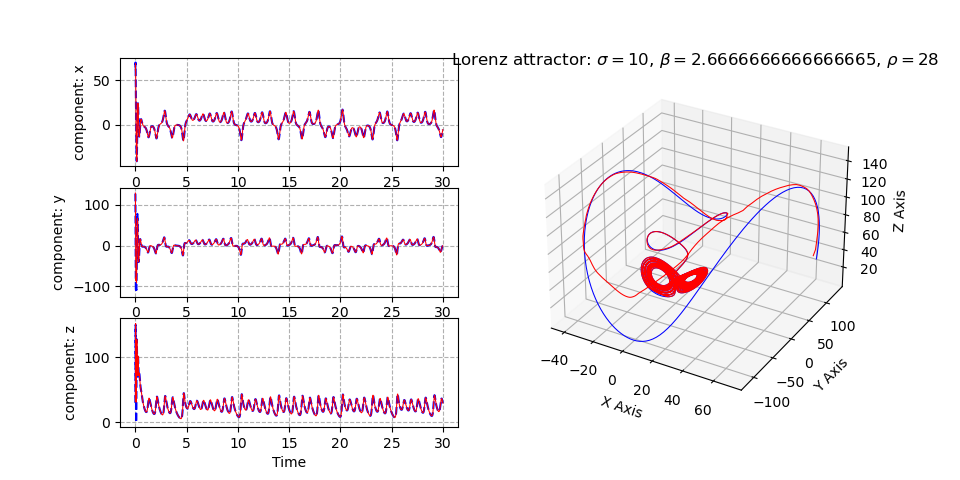

In [28]:
predict(Model, (64, 128, 30), 10, 8/3.0, 28)

For the lorenz butterfly the ANN model managed to predict accurate results similarly for changing the paramaters but for the example around extreme initial parameters it can be easily observed that the prediction fails to mimic the actual result. This is most likely due to overfitting the training data. Now we can measure the loss for varying the parameters and initial conditions to see how the model performed for various values.

In [29]:
testingSigma = np.arange(0, 20, 1)
testingRho = np.arange(0, 20, 1)

testingMesh = np.meshgrid(testingSigma, testingRho)

In [30]:
lossScores = []
for SIGMA in tqdm(testingSigma):
    for RHO in testingRho:
        LA = LorenzAttractor(t, INITIALSTATE, SIGMA, BETA, RHO)
        X, Y, Z = LA.get_states()
        attractor = np.array([X, Y, Z]).T

        lossScores.append(Model.evaluate(attractor[10000:20000], #validation data 
                                         attractor[10000+ndt:20000+ndt], 
                                         verbose = 0)[0]
                         )

100%|███████████████████████████████████████████| 20/20 [00:42<00:00,  2.11s/it]


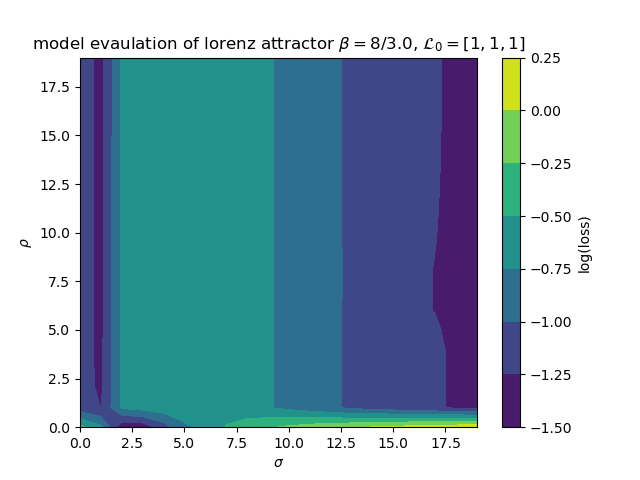

In [31]:
loss = np.asarray(lossScores).reshape(20,20)

fig, ax = plt.subplots()
plot = ax.contourf(testingSigma, testingRho, np.log10(loss))
ax.set_title(r"model evaulation of lorenz attractor $\beta=8/3.0$, $\mathcal{L}_0=[1,1,1]$")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\rho$")
cbar = fig.colorbar(plot, label="log(loss)")

In [32]:
testingX = np.arange(-40, 40, 2)
testingY = np.arange(-40, 40, 2)

testingMesh = np.meshgrid(testingX, testingY)

lossScores = []
for x in tqdm(testingX):
    for y in testingY:
        initialState= (x, y, 1.0)
        LA = LorenzAttractor(t, initialState, 10, 8/3.0, 28)
        X, Y, Z = LA.get_states()
        attractor = np.array([X, Y, Z]).T

        lossScores.append(Model.evaluate(attractor, #validation data 
                                         attractor, 
                                         verbose = 0)[0]
                         )

100%|███████████████████████████████████████████| 40/40 [07:26<00:00, 11.17s/it]


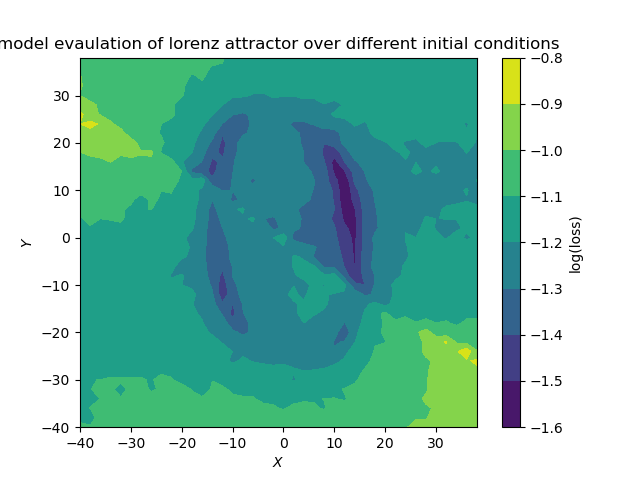

In [33]:
lossPoss = np.asarray(lossScores).reshape(40,40)

fig, ax = plt.subplots()
plot = ax.contourf(testingX, testingY, np.log10(lossPoss))
ax.set_title(r"model evaulation of lorenz attractor over different initial conditions")
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$Y$")
cbar = fig.colorbar(plot, label="log(loss)")

In [34]:
def OneDimHeatMap(Model, initialState, sigma, beta, rho):
    LA = LorenzAttractor(t, 
                         initialState=initialState, 
                         sigma=sigma, 
                         beta=beta, 
                         rho=rho)
    
    X, Y, Z = LA.get_states()
    attractor = np.array([X, Y, Z]).T
    differences = np.zeros_like(attractor)
    predicted = Model.predict(attractor)
    
    differences=np.absolute(predicted-attractor)
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.imshow(differences[:, i].reshape(1, -1), cmap='viridis', aspect='auto')
        plt.colorbar(label=f'Absolute Differences {i+1}')
        plt.title(f'Heat Map of Absolute Differences {i+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Coordinate Index')

    plt.tight_layout()
    plt.show()

938/938 [==============================] - 0s 277us/step


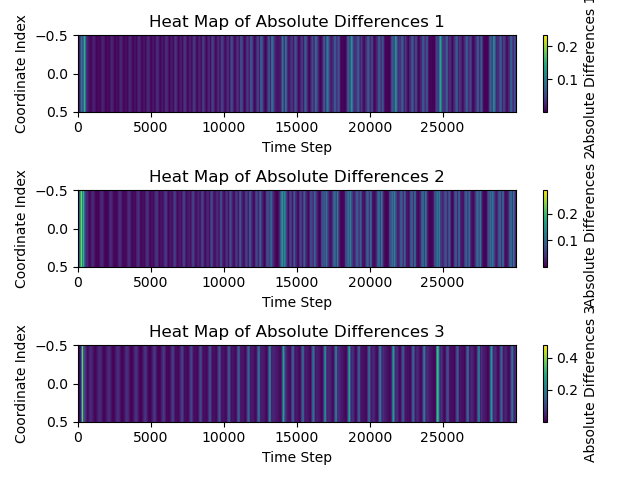

In [35]:
OneDimHeatMap(Model, (1.0,1.0,1.0), 10, 8/3.0, 28)

Two loss contour plots were analysed, in first loss contour plot $\rho$ and $\sigma$ were varied and in the second loss contour plot X and Y were varied. Since the model was only trained off the parameters and initial state of the lorenz butterfly dataset, seeing the loss for a range of the parameters is of intrigue. For the varying parameters of $\rho$ and $\sigma$ no trends can be observed. While for the second plot it can be observed that there is increasing loss as it moves away from the critical points. 

Lastly, the three one dimensional heat maps of positional difference between the predicted plot and actual plot demonstrate the difference between the plots where we see a periodic shape to higher difference. These could correlate to moments of the pitchfork bifurcation.[5]

<hr>
[5] https://en.wikipedia.org/wiki/Pitchfork_bifurcation

## Discussion and Conclusions

The results from the RNN model managed to capture the behaviour and general shape of the butterfly but were inaccurate along the z axis. This is believed to have occured due to the possible factors of adjusting the LSTM layer parameters, the model being incorrectly implemented, LSTM layers may not have the capibilities for non linear systems or that the training dataset does not have the variation it needs for generalization. This persisted when considering different parameters and initial states. The issue with the exaggerated initial states shows overfitting of the model to the training data set. For the ANN model a more accurate representation was achieved for the parameters of the lorenz butterfly and even changing the parameters but similar mispredictations for exaggerated initial states occured. Which is most likely due to overfitting of the training data.

Through this project the concepts of chaos theory and neural networks were studied, implemented and discussed. This was achieved by creating a lorenz butterfly class based off the strange attractor to create plots of the butterfly effect and to create a training data set for neural network models. Concepts of neural networks were studied to identify the preferred candidates for models to be implemented. Tensorflow and Keras packages were used for the creation and implementation of the RNN and ANN models.

Some possible further work could be done by adjusting the hyper parameters of the RNN model and implement the model differently, train the models based off numerous data sets with different parameters and initial states to streghten the capabalities of the models.